# Plot census data using geopandas

In [1]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame

import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union
import h3
import base64
import urllib
import tempfile

import matplotlib.pyplot as plt

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
zip_f = "nyc/tl_2020_36_tract.zip"

In [3]:
census_geo = gpd.read_file(zip_f)

In [4]:
census_geo.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,+40.6923505,-073.9973434,"POLYGON ((-74.00154 40.69279, -74.00132 40.693..."
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,+40.6917206,-073.9916018,"POLYGON ((-73.99405 40.69090, -73.99374 40.691..."
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,+40.6932903,-073.9877087,"POLYGON ((-73.99073 40.69305, -73.99045 40.693..."


In [5]:
commute = pd.read_csv('nyc/ny_commute_census_tract.csv')
commute = commute.drop(0,axis=0)

In [6]:
commute = commute.rename(columns={"FIPS": "GEOID"})

In [7]:
combined = census_geo.merge(commute, on='GEOID')

## Examining the comuting census data

## Examining the household census data

In [8]:
new_census = pd.read_csv('nyc/protected_attributes_ny_AMC2020_5year.csv', skiprows=[1])

In [9]:
census_df = pd.DataFrame()

In [10]:
pop_sex_columns = ["Total Population: Male",
                   "Total Population: Female",
                   "Total Population:"]
new_census[pop_sex_columns].info()
new_census[pop_sex_columns].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Total Population: Male    5411 non-null   int64
 1   Total Population: Female  5411 non-null   int64
 2   Total Population:         5411 non-null   int64
dtypes: int64(3)
memory usage: 126.9 KB


,Total Population: Male,Total Population: Female,Total Population:
0,890,1139,2029
1,1427,1836,3263
2,1059,1094,2153
3,1347,1669,3016
4,1287,1644,2931


In [11]:
census_df["male_population"] = new_census["Total Population: Male"] 
census_df["female_population"] = new_census["Total Population: Female"] 

In [12]:
census_df["total_population"] = new_census["Total Population:"]

In [13]:
census_df["total_population_white"] = new_census["Total Population: White Alone"] 
census_df["total_population_black"] = new_census["Total Population: Black or African American Alone"]
census_df["total_population_two_ormore_races"] = new_census["Total Population: Two or More Races"]
census_df["total_population_asian"] = new_census["Total Population: Asian Alone"] 


In [14]:
census_df["population_over_25"] = new_census["Population 25 Years and Over:"]
census_df["population_over_25_no_highschool"] = new_census["Population 25 Years and Over: Less than High School"]
census_df["population_over_25_highschool"] = new_census["Population 25 Years and Over: High School Graduate (Includes Equivalency)"] 
census_df["population_over_25_bachelor"] = new_census["Population 25 Years and Over: Bachelor's Degree"]
census_df["population_over_25_master"] = new_census["Population 25 Years and Over: Master's Degree"] 



In [15]:
census_df["households"] = new_census["Households:"]
census_df["households_0_to_50,000"] = new_census[["Households: Less than $10,000",
                                                    "Households: $10,000 to $14,999",
                                                    "Households: $15,000 to $19,999",
                                                    "Households: $20,000 to $24,999",
                                                    "Households: $25,000 to $29,999",
                                                    "Households: $30,000 to $34,999",
                                                    "Households: $35,000 to $39,999",
                                                    "Households: $40,000 to $44,999",
                                                    "Households: $45,000 to $49,999"]].sum(axis=1) 
census_df["households_over_50,000"] = new_census[["Households: $50,000 to $59,999",
                                                    "Households: $60,000 to $74,999",
                                                    "Households: $75,000 to $99,999",
                                                    "Households: $100,000 to $124,999",
                                                    "Households: $125,000 to $149,999",
                                                    "Households: $150,000 to $199,999",
                                                    "Households: $200,000 or More"]].sum(axis=1) 



In [16]:
census_df["GEOID"] = new_census["FIPS"].astype(str)

In [17]:
census_df.head().T

,0,1,2,3,4
male_population,890,1427,1059,1347,1287
female_population,1139,1836,1094,1669,1644
total_population,2029,3263,2153,3016,2931
total_population_white,481,643,86,847,1936
total_population_black,1141,2230,1968,1116,469
total_population_two_ormore_races,218,301,99,581,209
total_population_asian,99,89,0,393,257
population_over_25,1159,1906,1219,1805,2125
population_over_25_no_highschool,251,239,150,352,92
population_over_25_highschool,369,402,483,560,573


In [18]:
len(set(combined.GEOID))

5411

In [19]:
census_df.shape

(5411, 16)

In [20]:
combined = combined.merge(census_df, on="GEOID")

In [21]:
combined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5411 entries, 0 to 5410
Columns: 103 entries, STATEFP to households_over_50,000
dtypes: geometry(1), int64(17), object(85)
memory usage: 4.3+ MB


# Normalising columns

In [22]:
import seaborn as sns

```python 
corr_columns = ['Workers 16 Years and Over:',
                'Workers 16 Years and Over: Car, Truck, or Van',
                'Workers 16 Years and Over: Drove Alone',
                'Workers 16 Years and Over: Carpooled',
                'Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
                'Workers 16 Years and Over: Motorcycle',
                'Workers 16 Years and Over: Bicycle',
                'Workers 16 Years and Over: Walked',
                'Workers 16 Years and Over: Other Means',
                'Workers 16 Years and Over: Worked At Home',
                'Workers 16 Years and Over:.1',
                'Workers 16 Years and Over: Did Not Work At Home',
                'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
                'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes',
                'Workers 16 Years and Over: Worked At Home.1',
                'Average Commute to Work (In Min)', 'total_population', 'male_population',"female_population"
                'total_population_white', 'total_population_black',
                'total_population_two_ormore_races', 'total_population_asian',
                'population_over_25', 'population_over_25_no_highschool',
                'population_over_25_highschool', 'population_over_25_bachelor',
                'population_over_25_master', 'households', 'households_0_to_50,000',
                'households_over_50,000']
````


In [23]:
transport_time_cols = ['Workers 16 Years and Over:',
       'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes']
combined["Workers 16 Years and Over:"] = combined["Workers 16 Years and Over:"].astype(int)
combined[transport_time_cols] = combined[transport_time_cols].astype(int)
combined[transport_time_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 8 columns):
 #   Column                                                                 Non-Null Count  Dtype
---  ------                                                                 --------------  -----
 0   Workers 16 Years and Over:                                             5411 non-null   int64
 1   Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes  5411 non-null   int64
 2   Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes      5411 non-null   int64
 3   Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes      5411 non-null   int64
 4   Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes      5411 non-null   int64
 5   Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes      5411 non-null   int64
 6   Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes      5411 non-null   int64
 7   Workers

In [24]:

combined["comute_time_less_30min"] = combined[[
       'Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes']].sum(axis=1)/combined['Workers 16 Years and Over:']
combined["comute_time_more_30min"] = combined[['Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes',
       'Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes']].sum(axis=1)/combined['Workers 16 Years and Over:']
combined[["comute_time_less_30min", "comute_time_more_30min"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   comute_time_less_30min  5285 non-null   float64
 1   comute_time_more_30min  5285 non-null   float64
dtypes: float64(2)
memory usage: 126.8 KB


In [25]:
combined[["comute_time_less_30min", "comute_time_more_30min"]+ transport_time_cols].loc[combined[["comute_time_less_30min", "comute_time_more_30min"]].isna().any(axis=1)]

,comute_time_less_30min,comute_time_more_30min,Workers 16 Years and Over:,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes
38,NaN,NaN,0,0,0,0,0,0,0,0
68,NaN,NaN,0,0,0,0,0,0,0,0
127,NaN,NaN,0,0,0,0,0,0,0,0
133,NaN,NaN,0,0,0,0,0,0,0,0
405,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5301,NaN,NaN,0,0,0,0,0,0,0,0
5307,NaN,NaN,0,0,0,0,0,0,0,0
5352,NaN,NaN,0,0,0,0,0,0,0,0
5369,NaN,NaN,0,0,0,0,0,0,0,0


In [26]:
transport_cols = ['Workers 16 Years and Over:',
                'Workers 16 Years and Over: Car, Truck, or Van',
                'Workers 16 Years and Over: Drove Alone',
                'Workers 16 Years and Over: Carpooled',
                'Workers 16 Years and Over: Public Transportation (Includes Taxicab)',
                'Workers 16 Years and Over: Motorcycle',
                'Workers 16 Years and Over: Bicycle',
                'Workers 16 Years and Over: Walked',
                'Workers 16 Years and Over: Other Means',
                'Workers 16 Years and Over: Worked At Home']

combined[transport_cols] = combined[transport_cols].astype(int)
combined["over_16_puplictransportation"] = combined['Workers 16 Years and Over: Public Transportation (Includes Taxicab)'] /combined['Workers 16 Years and Over:']
combined["over_16_not_worked_home"] = combined['Workers 16 Years and Over: Worked At Home']/combined['Workers 16 Years and Over:']
combined["over_16_non_polution_transport"] = combined[['Workers 16 Years and Over: Bicycle','Workers 16 Years and Over: Walked']].sum(axis=1)/combined['Workers 16 Years and Over:']
combined["over_16_non_public_transport"] = combined[['Workers 16 Years and Over: Car, Truck, or Van',
                                                   'Workers 16 Years and Over: Drove Alone',
                                                   'Workers 16 Years and Over: Carpooled',
                                                   'Workers 16 Years and Over: Motorcycle',
                                                   'Workers 16 Years and Over: Other Means']].sum(axis=1) /combined['Workers 16 Years and Over:']

combined[["over_16_non_public_transport"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   over_16_non_public_transport  5285 non-null   float64
dtypes: float64(1)
memory usage: 84.5 KB


In [27]:
population_cols = ['male_population',
               'total_population_white', 'total_population_black',
               'total_population_two_ormore_races', 'total_population_asian',"female_population"]


combined[population_cols] = combined[population_cols].div(combined["total_population"], axis=0)

In [28]:
# 25 year cols 
education_25_cols = ['population_over_25_no_highschool',
               'population_over_25_highschool', 'population_over_25_bachelor',
               'population_over_25_master']
combined[education_25_cols] = combined[education_25_cols].div(combined["population_over_25"], axis=0)

In [29]:
# Household cols
household_cols = [ 'households_0_to_50,000',
               'households_over_50,000']
combined[household_cols] = combined[household_cols].div(combined["households"], axis=0)

In [30]:
normalized_cols = ['Average Commute to Work (In Min)',"over_16_puplictransportation",
                "over_16_not_worked_home",
                "over_16_non_polution_transport",
                "over_16_non_public_transport",
                "comute_time_less_30min",
                "comute_time_more_30min",
                 'male_population',
               'total_population_white', 'total_population_black',
               'total_population_two_ormore_races', 'total_population_asian',"female_population",
                'population_over_25_no_highschool',
               'population_over_25_highschool', 'population_over_25_bachelor',
               'population_over_25_master', 'households_0_to_50,000',
               'households_over_50,000']
combined[normalized_cols].head().T

,0,1,2,3,4
Average Commute to Work (In Min),36,29,32,30,39
over_16_puplictransportation,0.672611,0.651852,0.668067,0.5,0.606947
over_16_not_worked_home,0.138546,0.189198,0.126891,0.22973,0.0
over_16_non_polution_transport,0.137631,0.128395,0.07395,0.179834,0.268739
over_16_non_public_transport,0.102423,0.053086,0.178992,0.180873,0.248629
comute_time_less_30min,0.280293,0.382716,0.372269,0.288981,0.268739
comute_time_more_30min,0.581161,0.428086,0.50084,0.481289,0.731261
male_population,0.498846,0.485174,0.618509,0.518519,0.480373
total_population_white,0.84714,0.771594,0.701065,0.664058,0.40652
total_population_black,0.025391,0.038032,0.083222,0.104851,0.027279


In [31]:
combined[normalized_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
over_16_puplictransportation,5285.0,0.258915,0.258707,0.0,0.017826,0.158192,0.496970,1.000000
over_16_not_worked_home,5285.0,0.066065,0.057600,0.0,0.027451,0.053740,0.090563,1.000000
over_16_non_polution_transport,5285.0,0.066541,0.091792,0.0,0.010899,0.035889,0.085126,0.833333
over_16_non_public_transport,5285.0,1.208817,0.608961,0.0,0.632536,1.400913,1.767589,2.000000
comute_time_less_30min,5285.0,0.461728,0.223362,0.0,0.264269,0.448780,0.647541,1.000000
comute_time_more_30min,5285.0,0.472207,0.223623,0.0,0.286746,0.474557,0.668775,1.000000
male_population,5304.0,0.487676,0.060849,0.0,0.459979,0.487006,0.513109,1.000000
total_population_white,5304.0,0.624016,0.311514,0.0,0.352384,0.724652,0.902031,1.000000
total_population_black,5304.0,0.160862,0.236322,0.0,0.010671,0.045819,0.198446,1.000000
total_population_two_ormore_races,5304.0,0.045851,0.042526,0.0,0.015366,0.034288,0.064145,0.480000


In [32]:
combined[normalized_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Average Commute to Work (In Min)   5256 non-null   object 
 1   over_16_puplictransportation       5285 non-null   float64
 2   over_16_not_worked_home            5285 non-null   float64
 3   over_16_non_polution_transport     5285 non-null   float64
 4   over_16_non_public_transport       5285 non-null   float64
 5   comute_time_less_30min             5285 non-null   float64
 6   comute_time_more_30min             5285 non-null   float64
 7   male_population                    5304 non-null   float64
 8   total_population_white             5304 non-null   float64
 9   total_population_black             5304 non-null   float64
 10  total_population_two_ormore_races  5304 non-null   float64
 11  total_population_asian             5304 non-null   float

In [33]:
combined[normalized_cols].loc[combined[normalized_cols].isna().all(axis=1)]

,Average Commute to Work (In Min),over_16_puplictransportation,over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport,comute_time_less_30min,comute_time_more_30min,male_population,total_population_white,total_population_black,total_population_two_ormore_races,total_population_asian,female_population,population_over_25_no_highschool,population_over_25_highschool,population_over_25_bachelor,population_over_25_master,"households_0_to_50,000","households_over_50,000"
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
combined[normalized_cols].loc[combined[normalized_cols].isna().all(axis=1)]

,Average Commute to Work (In Min),over_16_puplictransportation,over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport,comute_time_less_30min,comute_time_more_30min,male_population,total_population_white,total_population_black,total_population_two_ormore_races,total_population_asian,female_population,population_over_25_no_highschool,population_over_25_highschool,population_over_25_bachelor,population_over_25_master,"households_0_to_50,000","households_over_50,000"
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
combined[normalized_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5411 entries, 0 to 5410
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Average Commute to Work (In Min)   5256 non-null   object 
 1   over_16_puplictransportation       5285 non-null   float64
 2   over_16_not_worked_home            5285 non-null   float64
 3   over_16_non_polution_transport     5285 non-null   float64
 4   over_16_non_public_transport       5285 non-null   float64
 5   comute_time_less_30min             5285 non-null   float64
 6   comute_time_more_30min             5285 non-null   float64
 7   male_population                    5304 non-null   float64
 8   total_population_white             5304 non-null   float64
 9   total_population_black             5304 non-null   float64
 10  total_population_two_ormore_races  5304 non-null   float64
 11  total_population_asian             5304 non-null   float

In [36]:
combined[normalized_cols] = combined[normalized_cols].loc[~combined[normalized_cols].isna().any(axis=1)]

In [37]:
combined.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,population_over_25_master,households,"households_0_to_50,000","households_over_50,000",comute_time_less_30min,comute_time_more_30min,over_16_puplictransportation,over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport
0,36,047,000700,36047000700,7,Census Tract 7,G5020,S,176774,0,...,0.264824,1669,0.158179,0.841821,0.280293,0.581161,0.672611,0.138546,0.137631,0.102423
1,36,047,000900,36047000900,9,Census Tract 9,G5020,S,163469,0,...,0.272213,2284,0.071804,0.928196,0.382716,0.428086,0.651852,0.189198,0.128395,0.053086
2,36,047,001100,36047001100,11,Census Tract 11,G5020,S,168507,0,...,0.261142,818,0.110024,0.889976,0.372269,0.500840,0.668067,0.126891,0.073950,0.178992
3,36,047,001300,36047001300,13,Census Tract 13,G5020,S,293167,0,...,0.343075,1021,0.287953,0.712047,0.288981,0.481289,0.500000,0.229730,0.179834,0.180873
4,36,047,002000,36047002000,20,Census Tract 20,G5020,S,154138,0,...,0.000000,388,0.577320,0.422680,0.268739,0.731261,0.606947,0.000000,0.268739,0.248629


In [38]:
combined['over_16_puplictransportation'].describe()

count    5241.000000
mean        0.258806
std         0.257479
min         0.000000
25%         0.018153
50%         0.159873
75%         0.496673
max         0.925049
Name: over_16_puplictransportation, dtype: float64

<AxesSubplot:>

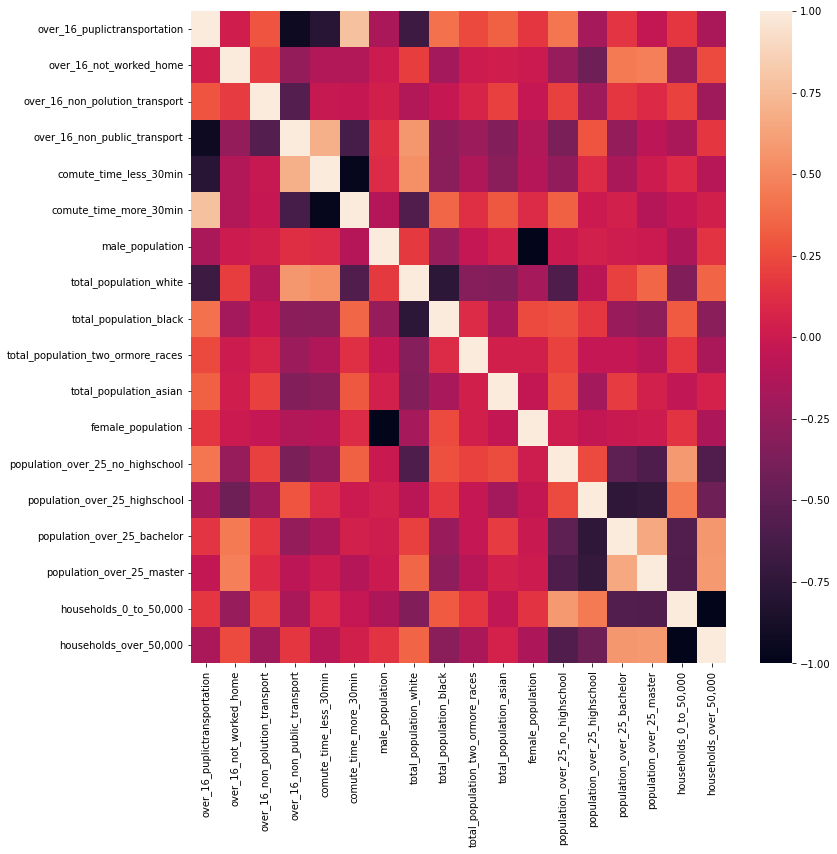

In [39]:
fig, ax = plt.subplots(1, figsize=(12,12))
corr = combined[normalized_cols].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [40]:
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


<AxesSubplot:>

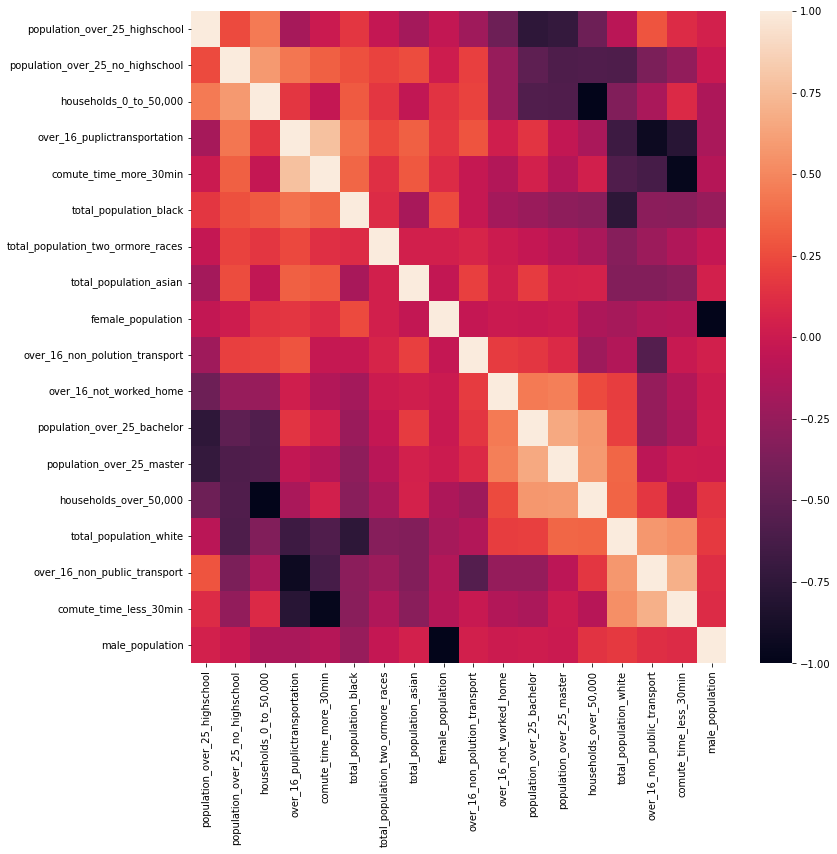

In [41]:
fig, ax = plt.subplots(1, figsize=(12,12))

sns.heatmap(cluster_corr(combined[normalized_cols].corr()))


In [42]:
combined = combined.to_crs("EPSG:4326")
combined.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Loading the stops


In [43]:
#Declare the directory path for the GTFS zip file
path = 'nyc/gtfs_zips/subway_gtfs.zip'

#Read the feed with gtfs-kit
feed = (gk.read_feed(path, dist_units='km'))

In [44]:
stops = feed.get_stops()
stops_geo = gpd.GeoDataFrame(
    stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat))

stops_geo = stops_geo.set_crs('EPSG:4326')

clean_stops_geo = stops_geo[(~stops_geo['geometry'].is_empty)&
                                      (~stops_geo['geometry'].isna())]

In [76]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
stops[hex_col] = stops.apply(lambda x: h3.geo_to_h3(x.stop_lat,x.stop_lon,APERTURE_SIZE),1)

# aggregate the points
stopsg = stops.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
stopsg['stop_lat'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
stopsg['stop_lon'] = stopsg[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [77]:
stopsg

,hex9,cnt,stop_lat,stop_lon
0,892a1001057ffff,3,40.877494,-73.864129
1,892a100106fffff,3,40.866803,-73.868027
2,892a100107bffff,3,40.872093,-73.868222
3,892a10010a7ffff,3,40.870057,-73.844548
4,892a10010dbffff,3,40.885486,-73.862275
...,...,...,...,...
442,892a1077527ffff,3,40.639538,-73.964327
443,892a1077533ffff,3,40.644813,-73.964532
444,892a1077547ffff,3,40.649743,-73.977536
445,892a107756bffff,3,40.644352,-73.981597


## Spatial analysis

In [46]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()
gdf = gdf.to_crs("EPSG:4326")

METRIC_COL = "over_16_non_public_transport"
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

In [47]:
sgdf = gpd.GeoDataFrame(stopsg, geometry=gpd.points_from_xy(stopsg.stop_lon, stopsg.stop_lat), crs=gdf.crs)
sgdf.head()

,hex9,cnt,stop_lat,stop_lon,geometry
0,892a1001057ffff,3,40.877494,-73.864129,POINT (-73.86413 40.87749)
1,892a100106fffff,3,40.866803,-73.868027,POINT (-73.86803 40.86680)
2,892a100107bffff,3,40.872093,-73.868222,POINT (-73.86822 40.87209)
3,892a10010a7ffff,3,40.870057,-73.844548,POINT (-73.84455 40.87006)
4,892a10010dbffff,3,40.885486,-73.862275,POINT (-73.86228 40.88549)


In [48]:
gdf = sgdf[["cnt", "geometry"]].sjoin(gdf, how="right", predicate='intersects').drop(columns=["index_left"]).fillna(0)

In [49]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2258 entries, 0 to 5410
Columns: 110 entries, cnt to over_16_non_public_transport
dtypes: float64(19), geometry(1), int64(65), object(25)
memory usage: 1.9+ MB


In [50]:
gdf.head().T

,0,1,2,2,3
cnt,0.0,3.0,6.0,6.0,3.0
STATEFP,36,36,36,36,36
COUNTYFP,047,047,047,047,047
TRACTCE,000700,000900,001100,001100,001300
GEOID,36047000700,36047000900,36047001100,36047001100,36047001300
...,...,...,...,...,...
comute_time_more_30min,0.581161,0.428086,0.50084,0.50084,0.481289
over_16_puplictransportation,0.672611,0.651852,0.668067,0.668067,0.5
over_16_not_worked_home,0.138546,0.189198,0.126891,0.126891,0.22973
over_16_non_polution_transport,0.137631,0.128395,0.07395,0.07395,0.179834


## Modelling

In [51]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [52]:
gdf.columns

Index(['cnt', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND',
       ...
       'population_over_25_master', 'households', 'households_0_to_50,000',
       'households_over_50,000', 'comute_time_less_30min',
       'comute_time_more_30min', 'over_16_puplictransportation',
       'over_16_not_worked_home', 'over_16_non_polution_transport',
       'over_16_non_public_transport'],
      dtype='object', length=110)

In [53]:
feature_col = ['cnt', 'Average Commute to Work (In Min)',
       'over_16_puplictransportation', 'over_16_not_worked_home',
       'over_16_non_polution_transport', 'over_16_non_public_transport',
       'comute_time_less_30min', 'comute_time_more_30min', 'male_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000']
target_col = 'over_16_puplictransportation'
feature_col = np.array([col for col in feature_col if col not in [target_col]])

In [54]:
regression_df = gdf[feature_col.tolist()+[target_col]].copy()
#regression_df['Average Commute to Work (In Min)'] = regression_df['Average Commute to Work (In Min)'].fillna("0").astype(float)

In [55]:
regression_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 0 to 5410
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   cnt                                2258 non-null   float64
 1   Average Commute to Work (In Min)   2258 non-null   object 
 2   over_16_not_worked_home            2258 non-null   float64
 3   over_16_non_polution_transport     2258 non-null   float64
 4   over_16_non_public_transport       2258 non-null   float64
 5   comute_time_less_30min             2258 non-null   float64
 6   comute_time_more_30min             2258 non-null   float64
 7   male_population                    2258 non-null   float64
 8   total_population_white             2258 non-null   float64
 9   total_population_black             2258 non-null   float64
 10  total_population_two_ormore_races  2258 non-null   float64
 11  total_population_asian             2258 non-null   float

<AxesSubplot:>

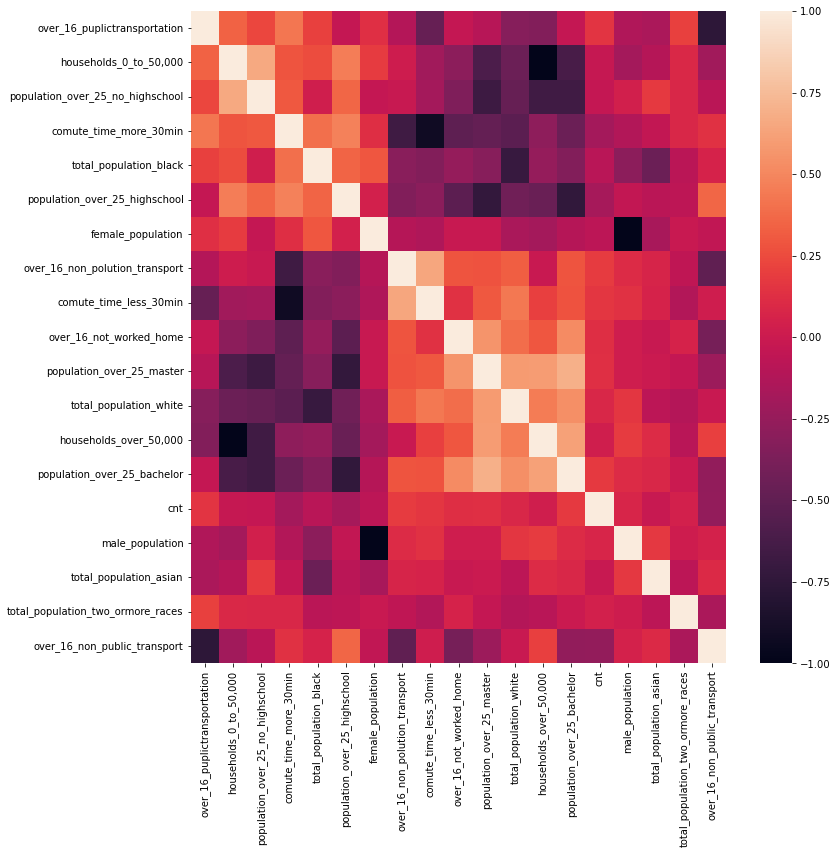

In [56]:
fig, ax = plt.subplots(1, figsize=(12,12))

sns.heatmap(cluster_corr(regression_df.corr()))

In [57]:
kf = KFold(n_splits=5)

X = regression_df[feature_col]
y = regression_df[target_col].values

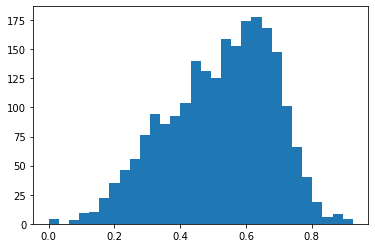

0.5227344100175356 0.16116019797770423


In [58]:
plt.hist(y, bins=30)
plt.show()
print(np.array(y).mean(),np.array(y).std())

In [59]:
feature_col

array(['cnt', 'Average Commute to Work (In Min)',
       'over_16_not_worked_home', 'over_16_non_polution_transport',
       'over_16_non_public_transport', 'comute_time_less_30min',
       'comute_time_more_30min', 'male_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000'], dtype='<U33')

In [60]:
X.head()

,cnt,Average Commute to Work (In Min),over_16_not_worked_home,over_16_non_polution_transport,over_16_non_public_transport,comute_time_less_30min,comute_time_more_30min,male_population,total_population_white,total_population_black,total_population_two_ormore_races,total_population_asian,female_population,population_over_25_no_highschool,population_over_25_highschool,population_over_25_bachelor,population_over_25_master,"households_0_to_50,000","households_over_50,000"
0,0.0,36,0.138546,0.137631,0.102423,0.280293,0.581161,0.498846,0.847140,0.025391,0.089254,0.023083,0.501154,0.024372,0.050564,0.415424,0.264824,0.158179,0.841821
1,3.0,29,0.189198,0.128395,0.053086,0.382716,0.428086,0.485174,0.771594,0.038032,0.084658,0.100774,0.514826,0.023425,0.025848,0.439688,0.272213,0.071804,0.928196
2,6.0,32,0.126891,0.073950,0.178992,0.372269,0.500840,0.618509,0.701065,0.083222,0.037949,0.152463,0.381491,0.008600,0.046912,0.454261,0.261142,0.110024,0.889976
2,6.0,32,0.126891,0.073950,0.178992,0.372269,0.500840,0.618509,0.701065,0.083222,0.037949,0.152463,0.381491,0.008600,0.046912,0.454261,0.261142,0.110024,0.889976
3,3.0,30,0.229730,0.179834,0.180873,0.288981,0.481289,0.518519,0.664058,0.104851,0.061033,0.127804,0.481481,0.013977,0.121982,0.245870,0.343075,0.287953,0.712047


In [61]:
preds = np.zeros(len(y))
coefs = np.zeros(len(X.columns))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5

In [62]:
idx = np.argsort(coefs)

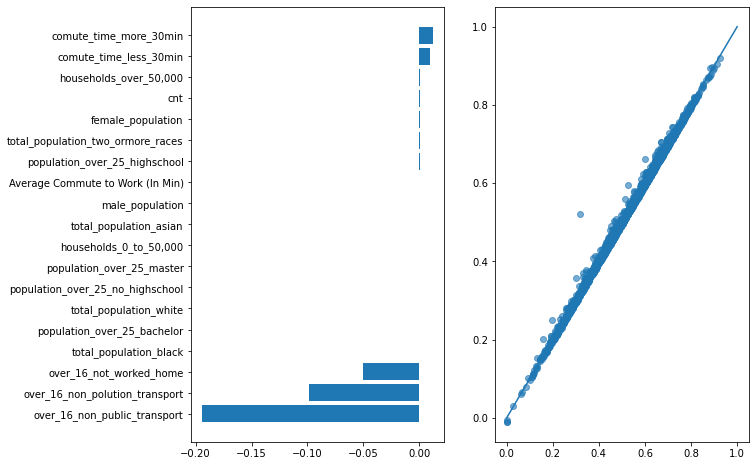

(0.008043518543826296, 0.9975089838091333)

In [63]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].barh(feature_col[idx],coefs[idx])

ax[1].scatter(y, preds, alpha=0.6)
ax[1].plot([i for i in range(2)])
plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

In [64]:
coefs

array([ 2.24526561e-04, -1.17048323e-04, -5.04440688e-02, -9.88010237e-02,
       -1.94044156e-01,  9.28771231e-03,  1.20127582e-02, -1.70578680e-04,
       -6.05351341e-04, -7.65255891e-04,  1.56811144e-04, -2.35821225e-04,
        1.70578680e-04, -4.90146080e-04,  1.38475020e-04, -7.02671402e-04,
       -4.14706384e-04, -3.58340949e-04,  3.58340949e-04])

In [65]:
feature_col

array(['cnt', 'Average Commute to Work (In Min)',
       'over_16_not_worked_home', 'over_16_non_polution_transport',
       'over_16_non_public_transport', 'comute_time_less_30min',
       'comute_time_more_30min', 'male_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000'], dtype='<U33')

In [66]:
feature_col =  np.array([col for col in feature_col if col not in ['over_16_non_public_transport', 'over_16_non_polution_transport']])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


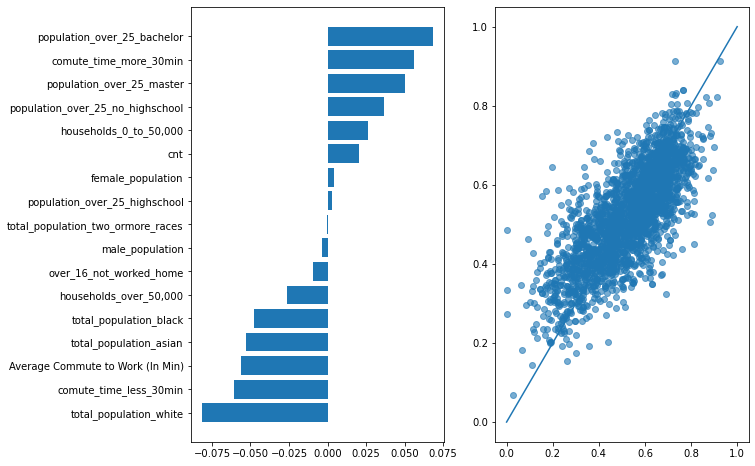

(0.10613286840767996, 0.5663051956903)

In [67]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)
ax[0].barh(feature_col[idx],coefs[idx])

ax[1].scatter(y, preds, alpha=0.6)
ax[1].plot([i for i in range(2)])
plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

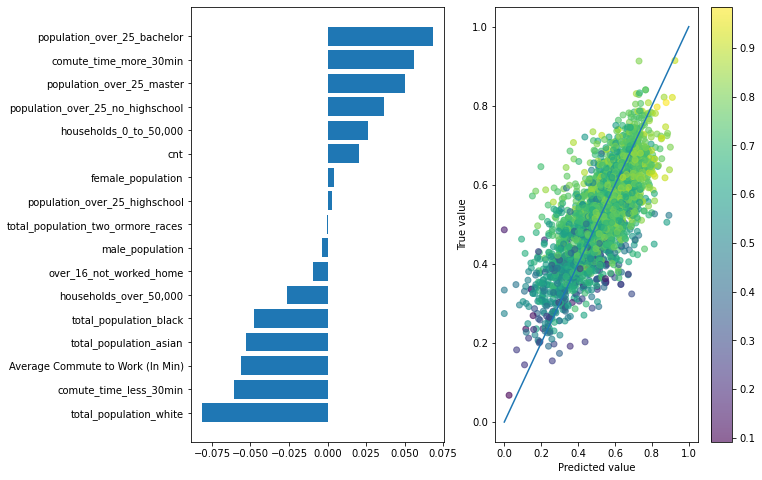

(0.10613286840767996, 0.5663051956903)

In [68]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].barh(feature_col[idx],coefs[idx])

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df["comute_time_more_30min"])
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1])

plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

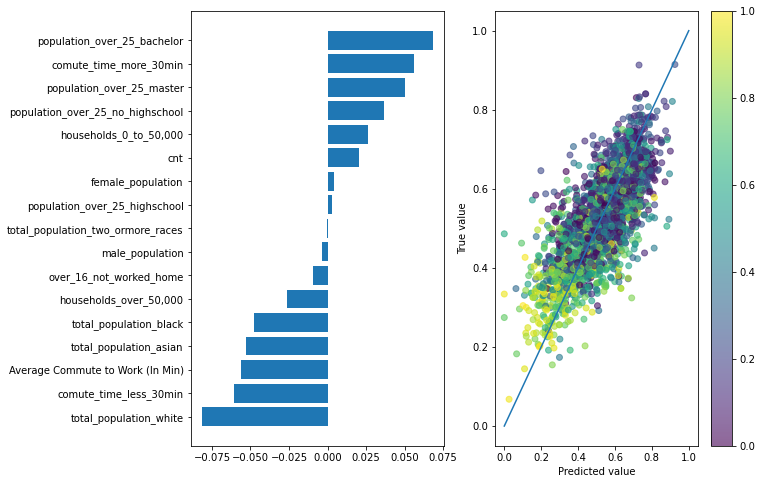

(0.10613286840767996, 0.5663051956903)

In [69]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)
ax[0].barh(np.array(feature_col)[idx],coefs[idx])

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df["total_population_white"])
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1])

plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

In [70]:
feature_col =  np.array([col for col in feature_col if col not in ['over_16_non_public_transport', "comute_time_more_30min"]])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


In [71]:
feature_col

array(['cnt', 'Average Commute to Work (In Min)',
       'over_16_not_worked_home', 'comute_time_less_30min',
       'male_population', 'total_population_white',
       'total_population_black', 'total_population_two_ormore_races',
       'total_population_asian', 'female_population',
       'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000'], dtype='<U33')

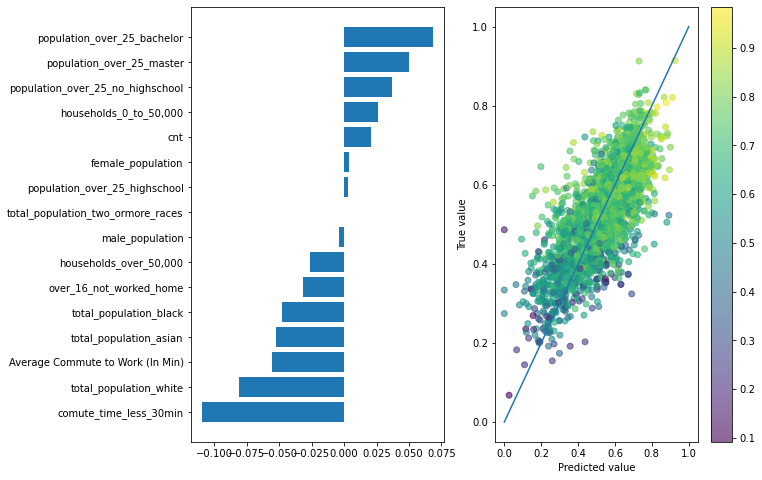

(0.10613314336486937, 0.5663029485512053)

In [72]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)

ax[0].barh(feature_col[idx],coefs[idx])

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df["comute_time_more_30min"])
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1])

plt.show()
mean_squared_error(y, preds, squared=False), r2_score(y, preds)

# Visualizing the results

In [73]:
#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis', basemap=None, ax=None):  
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df.plot.scatter(ax=ax, x=x, y=y, c="white", title=metric_col
                    , edgecolors='none', marker=marker, alpha=alpha, figsize=figsize);
    if basemap:
        ctx.add_basemap(ax=ax, crs=basemap)

    plt.xticks([], []); plt.yticks([], [])
    return ax
    

Text(0.5, 1.0, 'Prediction error')

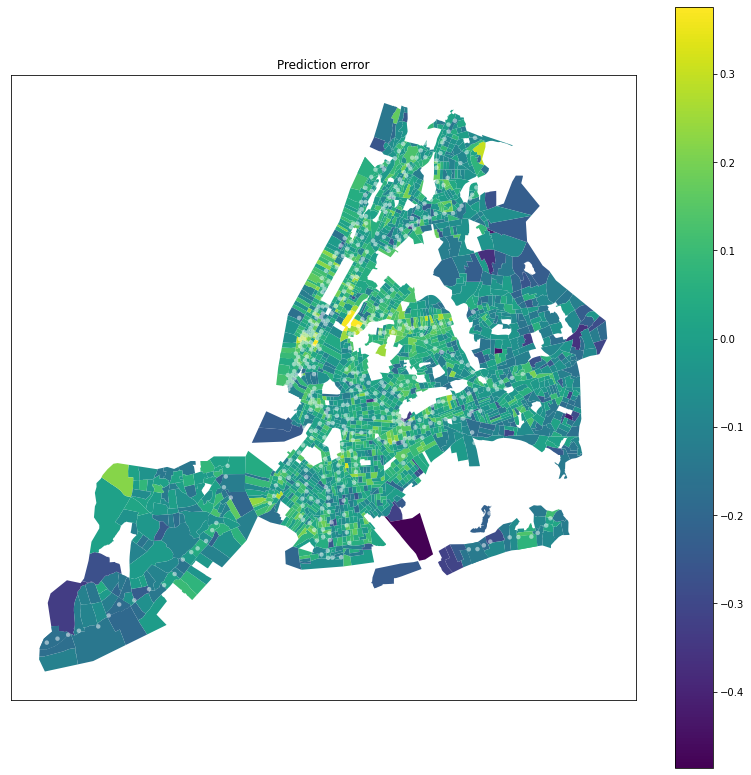

In [74]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(14,14))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax = plot_scatter(stopsg, metric_col='cnt', y="stop_lat", x="stop_lon", marker='o', basemap=gdf.crs.to_string(),ax=ax)
gdf["Prediction_diff"] = y - preds
ax = gdf.plot(column="Prediction_diff",cmap='viridis',alpha=1,linewidth=0.05,ax=ax, legend=True)
ax = stopsg.plot.scatter(ax=ax, y="stop_lat", x="stop_lon", marker="o", color="white", alpha=.5, edgecolors='none')

plt.title('Prediction error')